# Generar informe KMeans

**Input**

- HCE procesado con:
    - Extracción de categorías dietéticas
    - Normalización de los datos
    - Incorporación de las reglas extraídas de las guías clínicas

**Output:**
- Excel con N perfiles clínicos en el archivo 'perfiles_clinicos.xlsx'
- Excel con los registros de usuarios de cada cluster en la carpeta './archivos/cluster_outputs'
- Excel con el valor promedio (centroides) y la desviación estándar de cada variable de cada cluster en el archivo 'centroides_desviacion_estandar.xlsx'
- Resultados en el notebook de las variables más relevantes a la hora de hacer los clusters y con la información cuantitativa de los diagnósticos principales, diagnósticos asociados, medicación, consejo dietético y reglas de cada cluster

## Código

In [1]:
# Ruta donde se encuentra el HCE procesado
ruta_hce='./archivos/datos_gpt_con_40_ejemplos_reglas_v11.csv' #Debe ser en formato .csv

### Cargamos las librerías necesarias

In [2]:
import sys
sys.path.insert(1, '/home/eatitall_scripts')
sys.path.insert(1, '/home/root/pctobs/lib/python3.8/site-packages')
import pandas as pd
from sklearn.cluster import KMeans
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Cargamos el HCE

In [3]:
df=pd.read_csv(ruta_hce)

### Limpiamos los datos para poder aplicar algoritmos de clustering

In [4]:
def replace_nan_values(df):
    # Comprobar si hay valores NaN en el DataFrame y en qué columnas
    hay_nans = df.isnull().values.any()
    if hay_nans:
        print("Hay valores NaN en el DataFrame.")
        # Mostrar cuántos NaN hay por columna y listar las columnas que contienen NaN
        nans_por_columna = df.isnull().sum()
        print("\nNúmero de NaN por columna:")
        print(nans_por_columna[nans_por_columna > 0])  # Filtrar para mostrar solo las columnas con NaN
        # Identificar y listar explícitamente las columnas que tienen NaN
        columnas_con_nans = nans_por_columna[nans_por_columna > 0].index.tolist()
        print("\nColumnas que contienen NaNs:", columnas_con_nans)
        df=df.fillna(-100)
        print("Se han convertido cada NaN en un -100")
    else:
        print("No hay valores NaN en el DataFrame.")
    return df

def manage_string_values(df):
    columnas_string = [col for col in df.columns if df[col].dtype == 'object']
    df=df.drop(columnas_string,axis=1)
    print("Se han eliminado las siguientes columnas: ",columnas_string)
    return df


In [5]:
df=replace_nan_values(df) #Se reemplazan los valores NaN (valores ausentes) por lo que se indique en la función clustering.replace_nan_values(), por defecto NaN=-100
df=manage_string_values(df) #Se eliminan las columnas cuyos valores sean textos. Los algoritmos de clustering solo funcionan con valores numéricos. Por esta razón
                                       #es importante haber procesado previamente las variables textuales mediante la creación de variables dumpy, pero por si acaso ha quedado
                                       #alguna variable textual debe ser eliminada.

No hay valores NaN en el DataFrame.
Se han eliminado las siguientes columnas:  ['rec_nutricionales', 'cons_dietetico', 'ejer_fisico', 'juicio_cl']


## Aplicamos el algoritmo de clustering

In [6]:
def kmeans_algorithm(df,n_clusters=4,init='k-means++',n_init = 10,max_iter=500,tol=0.0001,random_state= 111,algorithm='elkan'):
    algorithm = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state, algorithm=algorithm)
    ## Aplica el algoritmo de k-means al conjunto de datos X1 para realizar el clustering. 
    ## Esto ajusta los centroides de los clústeres y asigna cada punto a un clúster.
    algorithm.fit(df)
    ## Cada etiqueta indica a qué clúster pertenece el punto.
    labels = algorithm.labels_
    ## Después de ajustar el modelo, esta línea guarda las coordenadas de los centroides de los clústeres en centroids1.
    centroids = algorithm.cluster_centers_
    return labels,centroids

In [7]:
n_clusters=4 #Definir el número de clusters deseados
labels_kmeans,centroids_kmeans=kmeans_algorithm(df,n_clusters=n_clusters,init='k-means++',n_init = 10,max_iter=500,tol=0.0001,random_state= 111,algorithm='elkan')

### Guardamos los registros de usuarios de cada cluster en la carpeta ./archivos/cluster_outputs

In [8]:
output_directory = './archivos/cluster_outputs'
os.makedirs(output_directory, exist_ok=True)

# Añadimos las etiquetas de los clusters al DataFrame original
df['cluster'] = labels_kmeans

# Crear un diccionario para almacenar DataFrames de cada cluster
cluster_dfs = {}

# Iterar sobre cada cluster y crear un DataFrame separado
for cluster_label in range(4):
    cluster_dfs[cluster_label] = df[df['cluster'] == cluster_label]

# Mostrar los DataFrames de cada cluster
for cluster_label, cluster_df in cluster_dfs.items():
    # print(f"DataFrame del Cluster {cluster_label}:\n")
    # print(cluster_df)
    # print("\n\n")
    # Guardar el DataFrame en un archivo Excel
    output_path = os.path.join(output_directory, f'cluster_{cluster_label}.xlsx')
    cluster_df.to_excel(output_path, index=False)
    # print(f'El DataFrame del Cluster {cluster_label} ha sido guardado en {output_path}')

In [9]:
# Crear dataframes para cada algoritmo con los centroides y el valor del cluster
def create_centroid_dataframe(df, centroids, algorithm_name):
    df_new=df.drop(columns=['cluster'])
    centroid_df = pd.DataFrame(centroids, columns=df_new.columns)
    centroid_df['cluster'] = range(len(centroids))
    centroid_df['algorithm'] = algorithm_name
    return centroid_df
df_kmeans_centroids = create_centroid_dataframe(df, centroids_kmeans, 'kmeans')

## Distribución de los clusters

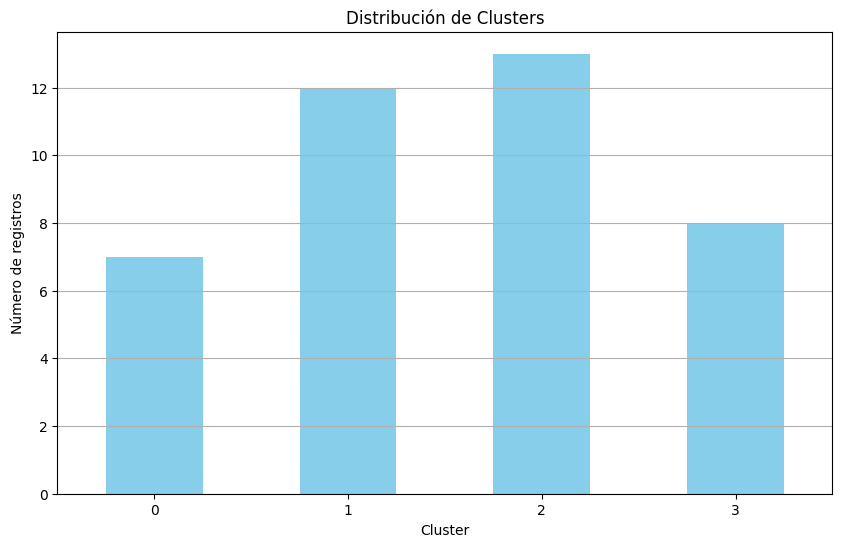

In [10]:
# Asumiendo que 'df' es tu DataFrame original y que tiene una columna 'cluster'
def plot_cluster_histogram(df):
    """
    Cuenta los valores de cada cluster y los representa en un histograma.

    :param df: pandas DataFrame, el DataFrame que contiene la columna 'cluster'.
    """
    # Contar los valores de cada cluster
    cluster_counts = df['cluster'].value_counts().sort_index()

    # Crear el histograma
    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribución de Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Número de registros')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

# Llamar a la función para representar el histograma
plot_cluster_histogram(df)


# Estadística

### Las variables más significativas para generar cada cluster (regresión lineal)


In [11]:

def linear_regresion(df):
    X = df.drop('cluster', axis=1)  # Todas las columnas excepto la variable objetivo
    y = df['cluster']  # Variable objetivo

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.coef_

    # Evaluar el modelo
    # print("Coeficientes:", model.coef_)
    print("Intercepto:", model.intercept_)
    print("Error cuadrático medio (MSE):", mean_squared_error(y_test, model.predict(X_test)))
    print("Coeficiente de determinación (R^2):", r2_score(y_test, model.predict(X_test)))

    # Mostrar la importancia de cada característica
    feature_importance = pd.DataFrame(model.coef_, X.columns, columns=['coeficiente'])
    # print(feature_importance.sort_values(by='coeficiente', ascending=False))
    return feature_importance

In [12]:
feature_importance=linear_regresion(df)
feature_sorted=feature_importance.sort_values(by='coeficiente', ascending=False)
for k in range(0,len(feature_sorted)):
    print(feature_sorted.iloc[k])

Intercepto: -26.65833288609417
Error cuadrático medio (MSE): 3.003153304894021
Coeficiente de determinación (R^2): -2.494578391149406
coeficiente    0.119808
Name: peso, dtype: float64
coeficiente    0.095642
Name: zinc, dtype: float64
coeficiente    0.066152
Name: talla, dtype: float64
coeficiente    0.066134
Name: gpt, dtype: float64
coeficiente    0.060633
Name: dx_principal_E12, dtype: float64
coeficiente    0.057105
Name: neuropatia, dtype: float64
coeficiente    0.046234
Name: glicosilada, dtype: float64
coeficiente    0.037602
Name: dx_asociados_K29, dtype: float64
coeficiente    0.037602
Name: medicamento_2_ej_med_K29, dtype: float64
coeficiente    0.037538
Name: reglas_corr_hba1c_fg, dtype: float64
coeficiente    0.03619
Name: dx_asociados_2_G56, dtype: float64
coeficiente    0.03462
Name: cobre, dtype: float64
coeficiente    0.033425
Name: medicamento_ej_med_E12_2, dtype: float64
coeficiente    0.032398
Name: plaquetas, dtype: float64
coeficiente    0.032252
Name: dx_asociado

### Los diagnósticos y medicamentos de cada cluster

In [13]:
def from_df_to_json(df, variables='diagnostico_principal'):
    if variables == 'diagnostico_principal':
        columnas = df.filter(regex='^dx_principal_').columns.tolist()
    
    if variables == 'diagnostico_asociado':
        columnas = df.filter(regex='^dx_asociados_').columns.tolist()

    if variables =='medicamento':
        columnas = df.filter(regex='^medicamento').columns.tolist()
    
    if variables =='consejo_dietetico':
        columnas = df.filter(regex='^categorias_cons_dietetico_').columns.tolist()

    if variables =='reglas':
        columnas = df.filter(regex='^reglas_').columns.tolist()

    recuento = {columna: int(df[columna].sum()) for columna in columnas}
    
    # Convertir el diccionario a JSON
    recuento_json = json.dumps(recuento)
        
    return recuento_json


#### Resultado de todos los clusters y todas las variables

In [14]:
resultados = {}

for cluster_id, df_cluster in cluster_dfs.items():
    df_cluster_reset = df_cluster.reset_index(drop=True)
    # Convertir los DataFrames a JSON
    json_dx_principal = from_df_to_json(df_cluster_reset, variables='diagnostico_principal')
    json_dx_asociado = from_df_to_json(df_cluster_reset, variables='diagnostico_asociado')
    json_medicamento = from_df_to_json(df_cluster_reset, variables='medicamento')
    json_consejo_dietetico = from_df_to_json(df_cluster_reset, variables='consejo_dietetico')
    json_reglas = from_df_to_json(df_cluster_reset, variables='reglas')

    # Convertir los JSON a diccionarios
    dict_dx_principal = json.loads(json_dx_principal)
    dict_dx_asociado = json.loads(json_dx_asociado)
    dict_medicamento = json.loads(json_medicamento)
    dict_consejo_dietetico = json.loads(json_consejo_dietetico)
    dict_reglas = json.loads(json_reglas)

    # Almacenar los diccionarios en el resultado
    resultados[cluster_id] = {
        'diagnosticos_principales': dict_dx_principal,
        'diagnosticos_asociados': dict_dx_asociado,
        'medicamentos': dict_medicamento,
        'consejo_dietetico': dict_consejo_dietetico,
        'reglas': dict_reglas
    }

# Función para ordenar y mostrar los resultados
def mostrar_ordenado(diccionario, titulo):
    print(f"{titulo} (de más frecuente a menos frecuente):")
    # Ordenar el diccionario por los valores de forma descendente
    for clave, valor in sorted(diccionario.items(), key=lambda item: item[1], reverse=True):
        print(f"{clave}: {valor}")
    print("\n")

# Mostrar los resultados ordenados para cada cluster
for cluster_id, diccionarios in resultados.items():
    print(f"Resultados para el cluster {cluster_id}:")
    mostrar_ordenado(diccionarios['diagnosticos_principales'], "Diagnósticos Principales")
    mostrar_ordenado(diccionarios['diagnosticos_asociados'], "Diagnósticos Asociados")
    mostrar_ordenado(diccionarios['medicamentos'], "Medicamentos")
    mostrar_ordenado(diccionarios['consejo_dietetico'], "Consejo dietético")
    mostrar_ordenado(diccionarios['reglas'], "Reglas")


Resultados para el cluster 0:
Diagnósticos Principales (de más frecuente a menos frecuente):
dx_principal_E12: 3
dx_principal_E11: 1
dx_principal_E13: 1


Diagnósticos Asociados (de más frecuente a menos frecuente):
dx_asociados_I63: 2
dx_asociados_K35: 2
dx_asociados_2_E78: 2
dx_asociados_2_F32.9: 2
dx_asociados_2_G62.9: 2
dx_asociados_3_E78.2: 2
dx_asociados_K29: 1
dx_asociados_N19: 1
dx_asociados_2_G56: 1
dx_asociados_3_E78.1: 1
dx_asociados_I11: 0
dx_asociados_I25: 0
dx_asociados_N18: 0
dx_asociados_2_E78.1: 0
dx_asociados_2_E78.2: 0
dx_asociados_2_H36: 0
dx_asociados_2_I70: 0
dx_asociados_2_L97: 0
dx_asociados_3_G99.0: 0
dx_asociados_3_H36: 0
dx_asociados_4_I25: 0
dx_asociados_4_N17-N19.9: 0


Medicamentos (de más frecuente a menos frecuente):
medicamento_ej_med_E10-E14.9_2: 2
medicamento_ej_med_E12_2: 2
medicamento_2_ej_med_I63: 2
medicamento_2_ej_med_K35: 2
medicamento_ej_med_E11_1: 1
medicamento_ej_med_E12_1: 1
medicamento_ej_med_E13_1: 1
medicamento_2_ej_med_I10_2: 1
medicamen

#### Con la siguiente función se puede seleccionar el cluster y la variable de la que se desea tener información

In [15]:
def mostrar_resultados_cluster_var(cluster_id, varX, resultados):
    # Verificar si el cluster existe en los resultados
    if cluster_id not in resultados:
        print(f"El cluster {cluster_id} no se encuentra en los resultados.")
        return
    
    # Obtener el diccionario de la variable especificada
    diccionario = resultados[cluster_id].get(varX, None)
    
    # Verificar si la variable existe para el cluster dado
    if diccionario is None:
        print(f"La variable '{varX}' no se encuentra para el cluster {cluster_id}.")
        return

    # Mostrar los resultados ordenados
    print(f"Resultados para el cluster {cluster_id} - {varX.capitalize()} (de más frecuente a menos frecuente):")
    for clave, valor in sorted(diccionario.items(), key=lambda item: item[1], reverse=True):
        print(f"{clave}: {valor}")
    print("\n")

# Uso de la función
mostrar_resultados_cluster_var(3, 'consejo_dietetico', resultados)


Resultados para el cluster 3 - Consejo_dietetico (de más frecuente a menos frecuente):
categorias_cons_dietetico_1_Reducir hidratos de carbono: 3
categorias_cons_dietetico_1_Dieta baja en grasas saturadas: 2
categorias_cons_dietetico_1_Aumentar proteínas: 1
categorias_cons_dietetico_2_Aumentar grasas: 1
categorias_cons_dietetico_1_Aumentar la toma de pescados azules: 0
categorias_cons_dietetico_1_Aumentar potasio: 0
categorias_cons_dietetico_1_Dieta Hipocalórica: 0
categorias_cons_dietetico_1_Reducir lácteos: 0
categorias_cons_dietetico_2_Aumentar el consumo de verduras: 0




## Desviación estándar de cada variable para cada cluster

Se calcula la desviación estandar para cada variable y se guarda en un excel

In [16]:
def desviacion_estandar_por_cluster(df, centroids, labels):
    """
    Calcula la desviación estándar de cada variable en el dataframe df para cada cluster, 
    utilizando los centroides y etiquetas (labels) resultantes del KMeans.
    
    Args:
    - df (pd.DataFrame): DataFrame con los datos originales.
    - centroids (np.array): Array con los centroides de los clusters.
    - labels (np.array): Array con las etiquetas de cada punto en el dataframe.

    Returns:
    - pd.DataFrame: DataFrame con las desviaciones estándar por cluster.
    """
    # Crear un DataFrame vacío para almacenar las desviaciones estándar
    desviaciones_estandar = pd.DataFrame(columns=df.columns)
    
    # Calcular la desviación estándar para cada cluster
    for cluster_id in range(len(centroids)):
        # Seleccionar las filas que pertenecen al cluster actual
        cluster_data = df[labels == cluster_id]
        
        # Calcular la desviación estándar de las variables en el cluster
        std_dev = cluster_data.std()
        
        # Añadir las desviaciones estándar calculadas al DataFrame
        desviaciones_estandar.loc[cluster_id] = std_dev
    
    return desviaciones_estandar


In [17]:
desviaciones_estandar=desviacion_estandar_por_cluster(df, centroids_kmeans, labels_kmeans)
desviaciones_estandar=desviaciones_estandar.drop(columns=['cluster'])
desviaciones_estandar

,edad,sexo,cisgenero,pa_sis,pa_dias,lugar_nac,dm,ecr_kdigo,comp_oftalmicas,neuropatia,...,reglas_bajo_nivel_insulina,reglas_hipoglucemia,reglas_tension_alta,reglas_hipertension,reglas_diabetes_con_hipertension,reglas_tratamiento_hipertension,reglas_recomendaciones_estilo_de_vida_hipertension,reglas_hipertension_resistente,reglas_recomendacion_medicacion_hipertension_con_enfermedad_renal,reglas_dislipemia_con_diabetes
0,9.889870,0.487950,0.0,19.388264,6.294366,0.0,0.0,0.0,0.377964,0.534522,...,0.0,0.0,0.534522,0.000000,0.0,0.377964,0.00000,0.377964,0.0,0.0
1,7.786449,0.514929,0.0,18.605148,3.816829,0.0,0.0,0.0,0.288675,0.522233,...,0.0,0.0,0.514929,0.288675,0.0,0.452267,0.00000,0.452267,0.0,0.0
2,10.969655,0.480384,0.0,15.993989,7.010066,0.0,0.0,0.0,0.000000,0.518875,...,0.0,0.0,0.518875,0.277350,0.0,0.506370,0.00000,0.506370,0.0,0.0
3,7.356969,0.517549,0.0,22.781180,4.780914,0.0,0.0,0.0,0.462910,0.517549,...,0.0,0.0,0.353553,0.534522,0.0,0.534522,0.46291,0.534522,0.0,0.0


In [18]:
def crear_dataframe_centroides_desviacion(centroids, desviaciones_estandar,filename='centroides_desviacion_estandar.xlsx'):
    """
    Crea un DataFrame para cada centroide con las columnas de valores de centroide y desviación estándar.
    
    Args:
    - centroids (np.array): Array con los centroides de los clusters.
    - desviaciones_estandar (pd.DataFrame): DataFrame con las desviaciones estándar por cluster.

    Returns:
    - dict: Un diccionario donde cada clave es el ID del cluster y cada valor es un DataFrame con
            los valores del centroide y las desviaciones estándar para cada variable.
    """
    cluster_dataframes = {}
    with pd.ExcelWriter(filename) as writer:
        for cluster_id in range(len(centroids)):
            # Extraer los valores del centroide y las desviaciones estándar para el cluster actual
            centroide = centroids[cluster_id]
            desviacion = desviaciones_estandar.loc[cluster_id].values
            
            # Crear un DataFrame con los valores y desviaciones estándar
            df_cluster = pd.DataFrame({
                'Variable': desviaciones_estandar.columns,
                'Valor_Centroide': centroide,
                'Desviacion_Estandar': desviacion
            })
            
            # Añadir el DataFrame al diccionario
            cluster_dataframes[cluster_id] = df_cluster

            # Guardar el DataFrame en una hoja del archivo Excel
            df_cluster.to_excel(writer, sheet_name=f'Cluster_{cluster_id}', index=False)
    
    return cluster_dataframes


In [19]:
crear_dataframe_centroides_desviacion(centroids_kmeans, desviaciones_estandar,filename='centroides_desviacion_estandar.xlsx')

{0:                                               Variable  Valor_Centroide  \
 0                                                 edad        62.857143   
 1                                                 sexo         1.714286   
 2                                            cisgenero         1.000000   
 3                                               pa_sis       161.285714   
 4                                              pa_dias        79.571429   
 ..                                                 ...              ...   
 143                    reglas_tratamiento_hipertension         0.857143   
 144  reglas_recomendaciones_estilo_de_vida_hiperten...         1.000000   
 145                     reglas_hipertension_resistente         0.857143   
 146  reglas_recomendacion_medicacion_hipertension_c...         0.000000   
 147                     reglas_dislipemia_con_diabetes         0.000000   
 
      Desviacion_Estandar  
 0               9.889870  
 1               0.487950  

## Perfiles clínicos (centroides normalizados)

Se detectan las variables binarias (0 o 1) y se define un umbral para identificar la presencia o ausencia de esa variable.

Se almacenan los valores de los umbrales de cada variable en un archivo de configuración json.

Se redondean los resultados con decimales a dos decimales.

Se guardan en un excel los resultados.

In [20]:
# Identificamos variables binarias.
def detect_binary_columns(dataframe):
    binary_columns = []
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        if set(unique_values).issubset({0, 1}):
            binary_columns.append(column)
    return binary_columns

In [21]:
binary_columns_full_df = detect_binary_columns(df)
binary_columns_full_df.append('sexo') #Es binaria pero no de 0,1 sino 1,2
print(f"Las columnas binarias son: {binary_columns_full_df}")


Las columnas binarias son: ['cisgenero', 'lugar_nac', 'ecr_kdigo', 'comp_oftalmicas', 'neuropatia', 'arterio_per', 'cardio_isq', 'ins_card', 'insulina_dep', 'tras_pancreaticos', 'ic_tipo', 'tabaquismo', 'alcoholismo', 'int_alimentaria', 'situacin_clnica_complete', 'valoracin_del_estado_nutricional_complete', 'recomendaciones_nutricionales_complete', 'dx_principal_E11', 'dx_principal_E12', 'dx_principal_E13', 'dx_asociados_I11', 'dx_asociados_I25', 'dx_asociados_I63', 'dx_asociados_K29', 'dx_asociados_K35', 'dx_asociados_N18', 'dx_asociados_N19', 'dx_asociados_2_E78', 'dx_asociados_2_E78.1', 'dx_asociados_2_E78.2', 'dx_asociados_2_F32.9', 'dx_asociados_2_G56', 'dx_asociados_2_G62.9', 'dx_asociados_2_H36', 'dx_asociados_2_I70', 'dx_asociados_2_L97', 'dx_asociados_3_E78.1', 'dx_asociados_3_E78.2', 'dx_asociados_3_G99.0', 'dx_asociados_3_H36', 'dx_asociados_4_I25', 'dx_asociados_4_N17-N19.9', 'medicamento_ej_med_E10-E14.9_2', 'medicamento_ej_med_E11_1', 'medicamento_ej_med_E11_2', 'medicam

In [22]:
# Cargamos el archivo de configuración
config_path='./archivos/config_perfiles_clinicos.json'
with open(config_path, 'r') as archivo:
    config_perfiles_clinicos = json.load(archivo)

In [23]:
# Aplicamos los valores definidos en el archivo de configuración para cada variable binaria 

df_kmeans_centroids_v2=df_kmeans_centroids
for columna in binary_columns_full_df:
    nombre_umbral='umbral_'+columna
    for k in range(0,len(df_kmeans_centroids_v2)):
        if columna=='sexo':
            if df_kmeans_centroids_v2[columna][k]>=config_perfiles_clinicos[columna][nombre_umbral]:
                df_kmeans_centroids_v2[columna][k]=2
            else:
                df_kmeans_centroids_v2[columna][k]=1
        else:
            if df_kmeans_centroids_v2[columna][k]>=config_perfiles_clinicos[columna][nombre_umbral]:
                df_kmeans_centroids_v2[columna][k]=1    
            else:
                df_kmeans_centroids_v2[columna][k]=0 

#Redondeando a dos decimales
df_kmeans_centroids_v2 = df_kmeans_centroids_v2.apply(lambda x: round(x, 2) if x.dtype == 'float' else x)

df_kmeans_centroids_v2.to_excel('perfiles_clinicos_v7.xlsx', index=False)

/tmp/ipykernel_27864/3893665377.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_centroids_v2[columna][k]=1
/tmp/ipykernel_27864/3893665377.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_centroids_v2[columna][k]=0
/tmp/ipykernel_27864/3893665377.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_centroids_v2[columna][k]=2
/tmp/ipykernel_27864/3893665377.py:11: SettingWithCopyWarning: 
A value is

# Extra: Decission Tree

In [24]:
# Filtrar las columnas que empiezan con 'dx_principal_'
columnas = df.filter(regex='^dx_principal_').columns.tolist()

# Crear una nueva columna para almacenar los resultados
df['dx_combined'] = 0  # Inicializar con -1 para identificar filas donde ninguna columna es 1

for i in range(1,len(columnas)+1):
    for j in range(0,len(df)):
        if df[columnas[i-1]][j]==1:
            df['dx_combined'][j]=i

/tmp/ipykernel_27864/997685133.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dx_combined'][j]=i


In [25]:
columnas.append('dx_combined')
columnas

['dx_principal_E11', 'dx_principal_E12', 'dx_principal_E13', 'dx_combined']

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

# Definir características (X) y variable objetivo (y)
X = df.drop(columns=columnas, axis=1)
y = df['dx_combined']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier(max_depth=5)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir con el modelo entrenado
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.3333333333333333
Confusion Matrix:
[[1 1 1 0]
 [2 2 0 0]
 [2 0 1 0]
 [1 1 0 0]]


In [27]:
# Calcular la precisión por hoja (clase)
true_positives = conf_matrix.diagonal()
totals_per_class = conf_matrix.sum(axis=1)
precision_per_leaf = true_positives / totals_per_class

# Mostrar la precisión por hoja
for i, precision in enumerate(precision_per_leaf):
    print(f'Precision for class {i}: {precision:.2%}')

Precision for class 0: 33.33%
Precision for class 1: 50.00%
Precision for class 2: 33.33%
Precision for class 3: 0.00%


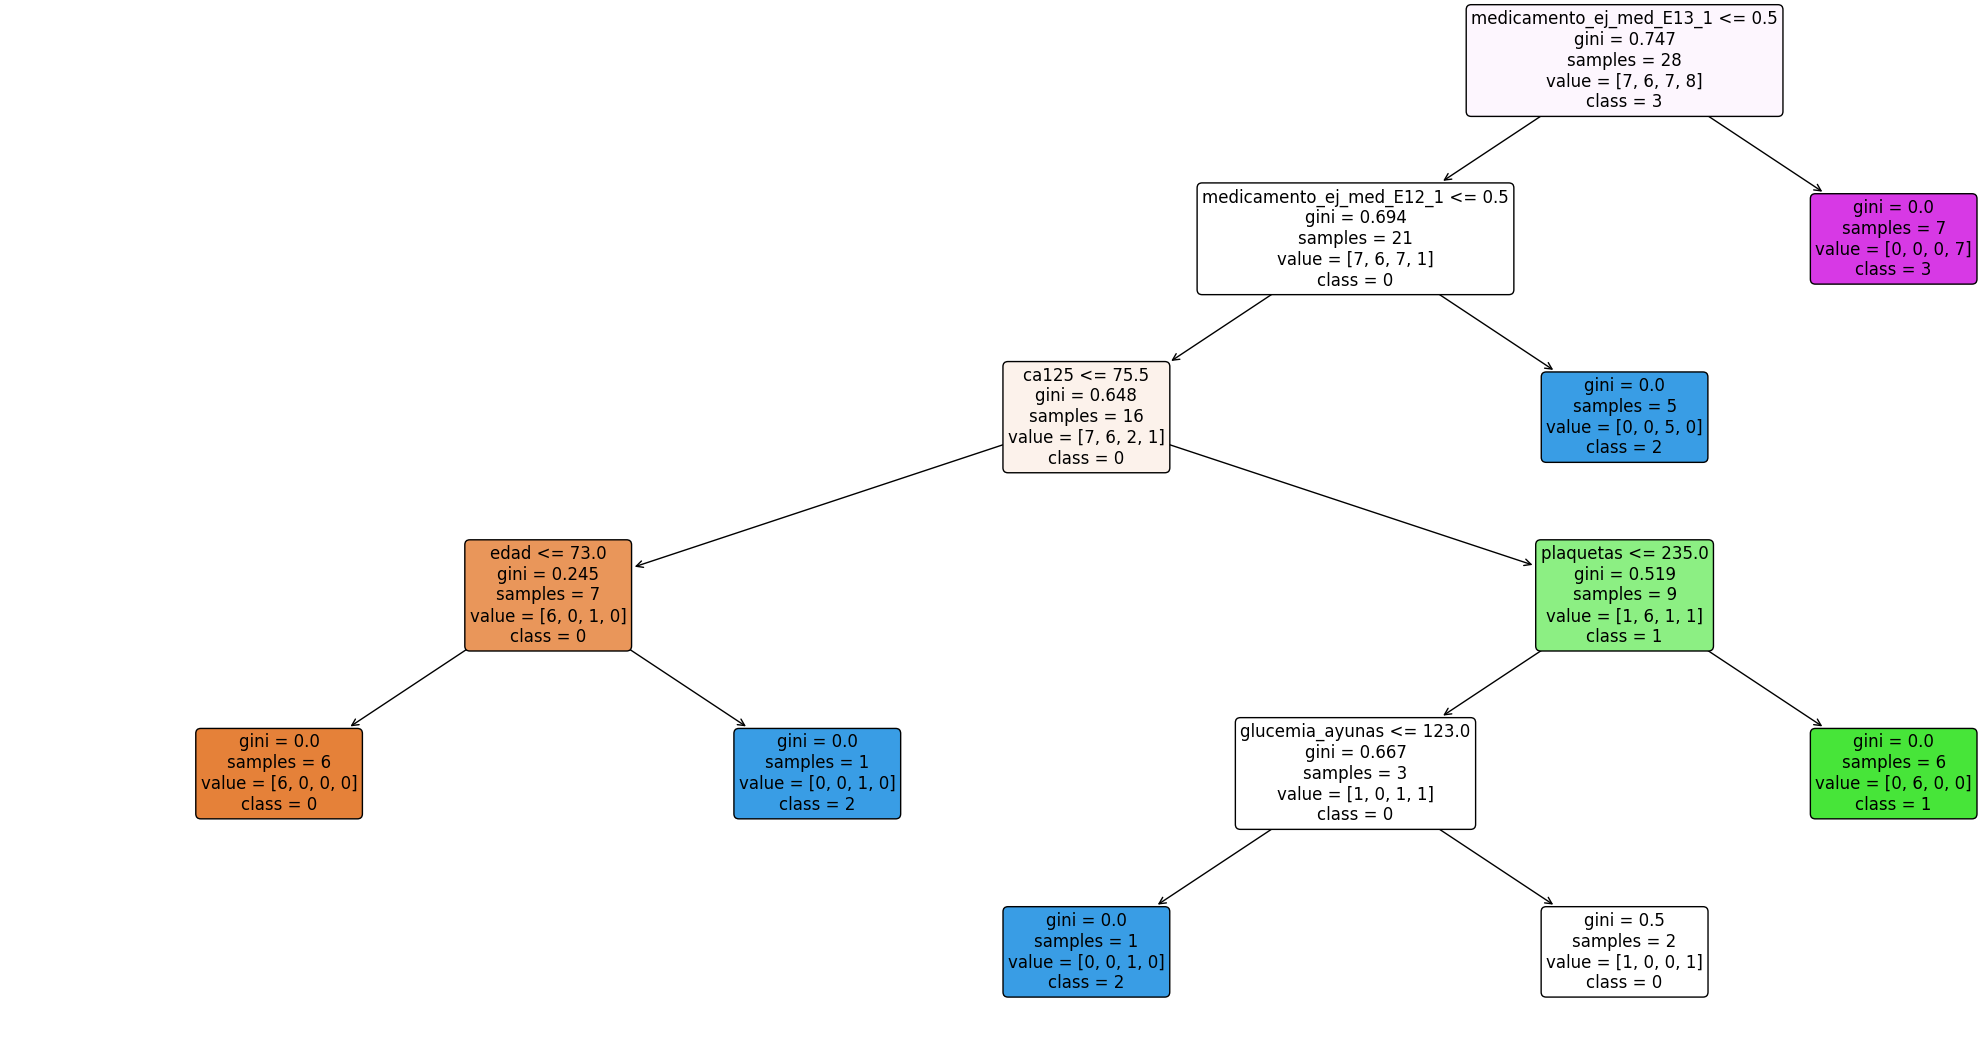

In [28]:
# Visualizar el árbol de decisión
plt.figure(figsize=(20,10))  # Ajustar el tamaño de la figura
class_names = list(map(str, model.classes_))

plot_tree(model, filled=True, feature_names=X.columns, class_names=class_names, rounded=True, fontsize=12)
plt.show()